<a href="https://colab.research.google.com/github/suhaaskarthik/comic-face-converter/blob/main/comic_generation_w_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

defileroff_comic_faces_paired_synthetic_path = kagglehub.dataset_download('defileroff/comic-faces-paired-synthetic')
suhaaskarthikeyan_checkpoint_path = kagglehub.dataset_download('suhaaskarthikeyan/checkpoint')
suhaaskarthikeyan_comicgen_path = kagglehub.dataset_download('suhaaskarthikeyan/comicgen')
suhaaskarthikeyan_facess_path = kagglehub.dataset_download('suhaaskarthikeyan/facess')

print('Data source import complete.')


In [ ]:
import tensorflow as tf

In [ ]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                    kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def load_testing_images(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)
  original_img = tf.cast(tf.image.resize(img, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR),dtype = tf.float32)
  original_img = (original_img / 127.5) - 1
  return original_img

In [ ]:
org = load_testing_images('/kaggle/input/facess/face.jpeg')

In [ ]:
import tensorflow as tf
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
      encode(128, 4), # (batch_size, 64, 64, 128)
      encode(256, 4), # (batch_size, 32, 32, 256)
      encode(512, 4), # (batch_size, 16, 16, 512)
      encode(512, 4), # (batch_size, 8, 8, 512)
      encode(512, 4), # (batch_size, 4, 4, 512)
      encode(512, 4), # (batch_size, 2, 2, 512)
      encode(512, 4), # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
      decode(512, 4), # (batch_size, 16, 16, 512)
      decode(256, 4), # (batch_size, 32, 32, 256)
      decode(128, 4), # (batch_size, 64, 64, 128)
      decode(64, 4), # (batch_size, 128, 128, 64)
  ]

  output_channels = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (batch_size, 256, 256, 3)

  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)
model2 = Generator()
model2.load_weights('/kaggle/input/comicgen/model_pix2pix.weights.h5')

(-0.5, 255.5, 255.5, -0.5)

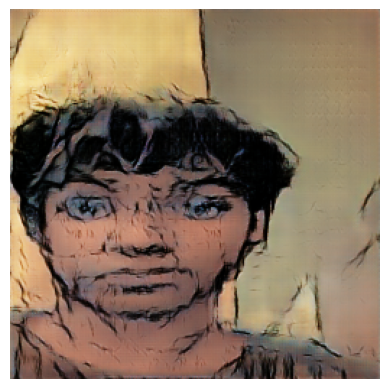

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
generated_img = model2(np.array([org]), training=True)
res = generated_img[0]
plt.imshow(res * 0.5 + 0.5)
plt.axis('off')

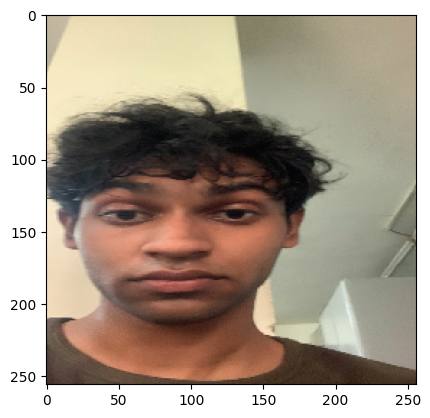

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
img = tf.io.read_file('/kaggle/input/faces5/faces5.jpg')
img = tf.image.decode_jpeg(img)
original_img = tf.cast(tf.image.resize(img, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR),dtype = tf.float32)
plt.imshow(original_img/255.)
plt.show()